Data Source https://www.kaggle.com/martinellis/nhl-game-data?select=game_plays.csv

NHL Game Data between 2010 and 2018 seasons

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import researchpy as rp #ResearchPy

from scipy.stats import chi2_contingency
from scipy.stats import chi2

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison


In [2]:
player = pd.read_csv('game_skater_stats.csv')
plays = pd.read_csv('game_plays.csv')
player_info = pd.read_csv('player_info.csv')
skater_stats= pd.read_csv('game_skater_stats.csv')
team_stats = pd.read_csv('game_teams_stats.csv')
team_info = pd.read_csv('team_info.csv')
teams = team_info.merge(team_stats, on='team_id')
players = player_info.merge(skater_stats, on='player_id')
game= pd.read_csv('game.csv')

# Plays

In [3]:
plays.shape

(3632349, 20)

In [4]:
nullplays= plays.isna().sum()
nullplays/len(plays)

play_id                0.000000
game_id                0.000000
play_num               0.000000
team_id_for            0.193093
team_id_against        0.193093
event                  0.000000
secondaryType          0.784459
x                      0.195173
y                      0.195168
period                 0.000000
periodType             0.000000
periodTime             0.000000
periodTimeRemaining    0.000000
dateTime               0.000000
goals_away             0.000000
goals_home             0.000000
description            0.000000
st_x                   0.195173
st_y                   0.195168
rink_side              0.216773
dtype: float64

In [5]:
plays.head()

,play_id,game_id,play_num,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,description,st_x,st_y,rink_side
0,2011030221_1,2011030221,1,NaN,NaN,Game Scheduled,NaN,NaN,NaN,1,REGULAR,0,1200,2012-04-29 18:16:06,0,0,Game Scheduled,NaN,NaN,NaN
1,2011030221_2,2011030221,2,NaN,NaN,Period Ready,NaN,NaN,NaN,1,REGULAR,0,1200,2012-04-29 19:19:49,0,0,Period Ready,NaN,NaN,NaN
2,2011030221_3,2011030221,3,NaN,NaN,Period Start,NaN,NaN,NaN,1,REGULAR,0,1200,2012-04-29 19:20:13,0,0,Period Start,NaN,NaN,NaN
3,2011030221_4,2011030221,4,4.0,1.0,Faceoff,NaN,0.0,0.0,1,REGULAR,0,1200,2012-04-29 19:20:13,0,0,Sean Couturier faceoff won against Patrik Elias,0.0,0.0,right
4,2011030221_5,2011030221,5,4.0,1.0,Giveaway,NaN,28.0,24.0,1,REGULAR,21,1179,2012-04-29 19:21:02,0,0,Giveaway by Kimmo Timonen,-28.0,-24.0,right


In [6]:
plays.columns

Index(['play_id', 'game_id', 'play_num', 'team_id_for', 'team_id_against',
       'event', 'secondaryType', 'x', 'y', 'period', 'periodType',
       'periodTime', 'periodTimeRemaining', 'dateTime', 'goals_away',
       'goals_home', 'description', 'st_x', 'st_y', 'rink_side'],
      dtype='object')

In [7]:
plays.event.unique()

array(['Game Scheduled', 'Period Ready', 'Period Start', 'Faceoff',
       'Giveaway', 'Blocked Shot', 'Shot', 'Hit', 'Stoppage', 'Goal',
       'Penalty', 'Takeaway', 'Missed Shot', 'Period End',
       'Period Official', 'Game End', 'Game Official',
       'Official Challenge', 'Shootout Complete',
       'Early Intermission Start', 'Early Intermission End',
       'Emergency Goaltender'], dtype=object)

In [8]:
plays['event']

0           Game Scheduled
1             Period Ready
2             Period Start
3                  Faceoff
4                 Giveaway
                ...       
3632344            Faceoff
3632345               Shot
3632346         Period End
3632347    Period Official
3632348           Game End
Name: event, Length: 3632349, dtype: object

## Shots

In [9]:
#Plays that are shots
shots=plays[(plays.event == 'Shot') | (plays.event == 'Missed Shot') | (plays.event == 'Blocked Shot') | (plays.event == 'Shot')]
shots.head()

,play_id,game_id,play_num,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,description,st_x,st_y,rink_side
5,2011030221_6,2011030221,6,4.0,1.0,Blocked Shot,NaN,52.0,28.0,1,REGULAR,26,1174,2012-04-29 19:21:07,0,0,Max Talbot blocked shot from Patrik Elias,-52.0,-28.0,right
6,2011030221_7,2011030221,7,1.0,4.0,Shot,Wrist Shot,80.0,-3.0,1,REGULAR,30,1170,2012-04-29 19:21:12,0,0,Patrik Elias Wrist Shot saved by Ilya Bryzgalov,80.0,-3.0,left
11,2011030221_12,2011030221,12,1.0,4.0,Shot,Wrap-around,88.0,-4.0,1,REGULAR,139,1061,2012-04-29 19:23:29,0,0,Ryan Carter Wrap-around saved by Ilya Bryzgalov,88.0,-4.0,left
12,2011030221_13,2011030221,13,1.0,4.0,Shot,Wrist Shot,81.0,-27.0,1,REGULAR,154,1046,2012-04-29 19:23:44,0,0,Stephen Gionta Wrist Shot saved by Ilya Bryzgalov,81.0,-27.0,left
24,2011030221_25,2011030221,25,1.0,4.0,Shot,Snap Shot,63.0,-19.0,1,REGULAR,274,926,2012-04-29 19:28:00,1,0,Travis Zajac Snap Shot saved by Ilya Bryzgalov,63.0,-19.0,left


There are three kinds of shots: shots on goal (shot), missed shot, and blocked shot

blocked shots for corsi rating, use team_id_against; otherwise use team_id_for

In [10]:
shots.shape

(1217675, 20)

In [11]:
shotsg= shots.groupby(shots['event'])

In [12]:
shotsg.head()

,play_id,game_id,play_num,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,description,st_x,st_y,rink_side
5,2011030221_6,2011030221,6,4.0,1.0,Blocked Shot,NaN,52.0,28.0,1,REGULAR,26,1174,2012-04-29 19:21:07,0,0,Max Talbot blocked shot from Patrik Elias,-52.0,-28.0,right
6,2011030221_7,2011030221,7,1.0,4.0,Shot,Wrist Shot,80.0,-3.0,1,REGULAR,30,1170,2012-04-29 19:21:12,0,0,Patrik Elias Wrist Shot saved by Ilya Bryzgalov,80.0,-3.0,left
11,2011030221_12,2011030221,12,1.0,4.0,Shot,Wrap-around,88.0,-4.0,1,REGULAR,139,1061,2012-04-29 19:23:29,0,0,Ryan Carter Wrap-around saved by Ilya Bryzgalov,88.0,-4.0,left
12,2011030221_13,2011030221,13,1.0,4.0,Shot,Wrist Shot,81.0,-27.0,1,REGULAR,154,1046,2012-04-29 19:23:44,0,0,Stephen Gionta Wrist Shot saved by Ilya Bryzgalov,81.0,-27.0,left
24,2011030221_25,2011030221,25,1.0,4.0,Shot,Snap Shot,63.0,-19.0,1,REGULAR,274,926,2012-04-29 19:28:00,1,0,Travis Zajac Snap Shot saved by Ilya Bryzgalov,63.0,-19.0,left
25,2011030221_26,2011030221,26,1.0,4.0,Shot,Snap Shot,68.0,1.0,1,REGULAR,282,918,2012-04-29 19:28:08,1,0,Travis Zajac Snap Shot saved by Ilya Bryzgalov,68.0,1.0,left
33,2011030221_34,2011030221,34,1.0,4.0,Missed Shot,NaN,74.0,-27.0,1,REGULAR,417,783,2012-04-29 19:31:13,1,0,Ryan Carter - Wide of Net,74.0,-27.0,left
37,2011030221_38,2011030221,38,4.0,1.0,Blocked Shot,NaN,53.0,10.0,1,REGULAR,427,773,2012-04-29 19:33:34,1,0,Jaromir Jagr blocked shot from Bryce Salvador,-53.0,-10.0,right
38,2011030221_39,2011030221,39,4.0,1.0,Blocked Shot,NaN,46.0,-17.0,1,REGULAR,441,759,2012-04-29 19:33:48,1,0,Scott Hartnell blocked shot from Marek Zidlicky,-46.0,17.0,right
46,2011030221_47,2011030221,47,4.0,1.0,Blocked Shot,NaN,61.0,18.0,1,REGULAR,534,666,2012-04-29 19:35:51,1,0,Andreas Lilja blocked shot from Anton Volchenkov,-61.0,-18.0,right


In [13]:
Goals = plays[plays['event']== 'Goal']
totalgoals= Goals.groupby('secondaryType').count()

[Text(0, 0, 'Wrist Shot'),
 Text(0, 0, 'Snap Shot'),
 Text(0, 0, 'Slap Shot'),
 Text(0, 0, 'Backhand'),
 Text(0, 0, 'Tip-In'),
 Text(0, 0, 'Deflected'),
 Text(0, 0, 'Wrap-around')]

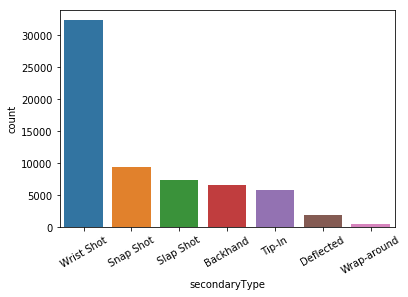

In [14]:
plot = sns.countplot(x = 'secondaryType',
                    data = Goals,
                    order = Goals['secondaryType'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation = 30)

# Players

In [15]:
players.head()

,player_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,link,game_id,team_id,...,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce
0,8467412,Alexei,Ponikarovsky,UKR,Kiev,LW,1980-04-09,/api/v1/people/8467412,2011030221,1,...,0,0,0,0,0,0,-1,885,98,16
1,8467412,Alexei,Ponikarovsky,UKR,Kiev,LW,1980-04-09,/api/v1/people/8467412,2011030222,1,...,0,0,0,0,0,1,0,919,54,20
2,8467412,Alexei,Ponikarovsky,UKR,Kiev,LW,1980-04-09,/api/v1/people/8467412,2011030223,1,...,1,0,0,0,0,0,1,1023,68,0
3,8467412,Alexei,Ponikarovsky,UKR,Kiev,LW,1980-04-09,/api/v1/people/8467412,2011030224,1,...,0,0,0,0,0,0,1,899,41,55
4,8467412,Alexei,Ponikarovsky,UKR,Kiev,LW,1980-04-09,/api/v1/people/8467412,2011030225,1,...,1,0,0,0,0,1,1,636,40,12


In [16]:
players.columns

Index(['player_id', 'firstName', 'lastName', 'nationality', 'birthCity',
       'primaryPosition', 'birthDate', 'link', 'game_id', 'team_id',
       'timeOnIce', 'assists', 'goals', 'shots', 'hits', 'powerPlayGoals',
       'powerPlayAssists', 'penaltyMinutes', 'faceOffWins', 'faceoffTaken',
       'takeaways', 'giveaways', 'shortHandedGoals', 'shortHandedAssists',
       'blocked', 'plusMinus', 'evenTimeOnIce', 'shortHandedTimeOnIce',
       'powerPlayTimeOnIce'],
      dtype='object')

In [17]:
players.shape

(411578, 29)

In [18]:
player = pd.merge(player, player_info, on ='player_id', how = 'left')
player =pd.merge(player, team_info, on = 'team_id', how = 'left')
player.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,nationality,birthCity,primaryPosition,birthDate,link_x,franchiseId,shortName,teamName,abbreviation,link_y
0,2011030221,8467412,1,999,0,0,1,3,0,0,...,UKR,Kiev,LW,1980-04-09,/api/v1/people/8467412,23,New Jersey,Devils,NJD,/api/v1/teams/1
1,2011030221,8468501,1,1168,0,0,0,4,0,0,...,RUS,Moscow,D,1982-02-25,/api/v1/people/8468501,23,New Jersey,Devils,NJD,/api/v1/teams/1
2,2011030221,8470609,1,558,0,0,2,1,0,0,...,CAN,Quebec City,RW,1985-03-31,/api/v1/people/8470609,23,New Jersey,Devils,NJD,/api/v1/teams/1
3,2011030221,8471816,1,1134,0,0,1,4,0,0,...,USA,Nashua,D,1987-05-15,/api/v1/people/8471816,23,New Jersey,Devils,NJD,/api/v1/teams/1
4,2011030221,8472410,1,436,0,0,1,3,0,0,...,USA,Rochester,RW,1983-10-09,/api/v1/people/8472410,23,New Jersey,Devils,NJD,/api/v1/teams/1


Text(0.5, 1.0, 'Time on Ice Distribution by Minutes')

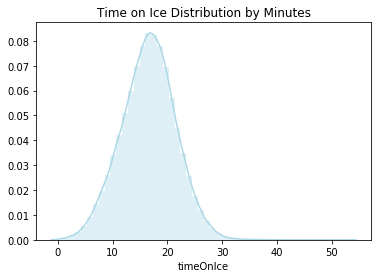

In [19]:
dist=sns.distplot(player.timeOnIce/60, color='lightblue')
dist.set_title('Time on Ice Distribution by Minutes')

In [20]:
player['timeOnIce'].describe()

count    411578.000000
mean        993.614911
std         297.877325
min           1.000000
25%         798.000000
50%        1001.000000
75%        1192.000000
max        3197.000000
Name: timeOnIce, dtype: float64

In [21]:
993/60

16.55

In [22]:
player['GoalsPerMin']= (player.goals*60)/player.timeOnIce
player['PointsPerMin']=(player.assists + player.goals)*60/player.timeOnIce
player.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,primaryPosition,birthDate,link_x,franchiseId,shortName,teamName,abbreviation,link_y,GoalsPerMin,PointsPerMin
0,2011030221,8467412,1,999,0,0,1,3,0,0,...,LW,1980-04-09,/api/v1/people/8467412,23,New Jersey,Devils,NJD,/api/v1/teams/1,0.0,0.0
1,2011030221,8468501,1,1168,0,0,0,4,0,0,...,D,1982-02-25,/api/v1/people/8468501,23,New Jersey,Devils,NJD,/api/v1/teams/1,0.0,0.0
2,2011030221,8470609,1,558,0,0,2,1,0,0,...,RW,1985-03-31,/api/v1/people/8470609,23,New Jersey,Devils,NJD,/api/v1/teams/1,0.0,0.0
3,2011030221,8471816,1,1134,0,0,1,4,0,0,...,D,1987-05-15,/api/v1/people/8471816,23,New Jersey,Devils,NJD,/api/v1/teams/1,0.0,0.0
4,2011030221,8472410,1,436,0,0,1,3,0,0,...,RW,1983-10-09,/api/v1/people/8472410,23,New Jersey,Devils,NJD,/api/v1/teams/1,0.0,0.0


In [23]:
playeractive= player[player['timeOnIce']>= 300]
top10players = playeractive.nlargest(10, 'GoalsPerMin')
top10players = top10players[['firstName', 'lastName', 'primaryPosition', 'GoalsPerMin', 'goals']]
top10players

,firstName,lastName,primaryPosition,GoalsPerMin,goals
75700,Tomas,Hertl,C,0.357143,4
380560,Zach,Parise,LW,0.312500,3
186046,Frank,Vatrano,C,0.292208,3
74183,Nick,Bonino,C,0.289389,3
314224,Matt,Kassian,LW,0.280374,2
235728,Patrice,Bergeron,C,0.279720,4
341432,Blake,Geoffrion,C,0.279070,3
286713,Andreas,Johnsson,LW,0.277778,3
221364,Scott,Hartnell,LW,0.275229,3
236623,Jack,Skille,RW,0.273349,2


In [24]:
player['Points']= player.goals +player.assists

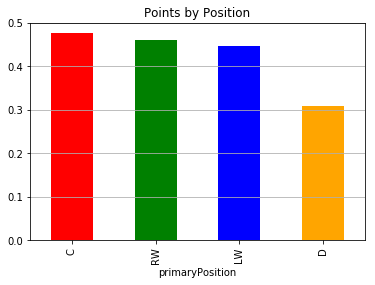

In [25]:
positions=player.groupby('primaryPosition').Points.mean().loc[["C", "RW", "LW","D"]].plot(kind='bar',color=['r', 'g', 'b', 'orange'],title='Points by Position').grid(axis='y')

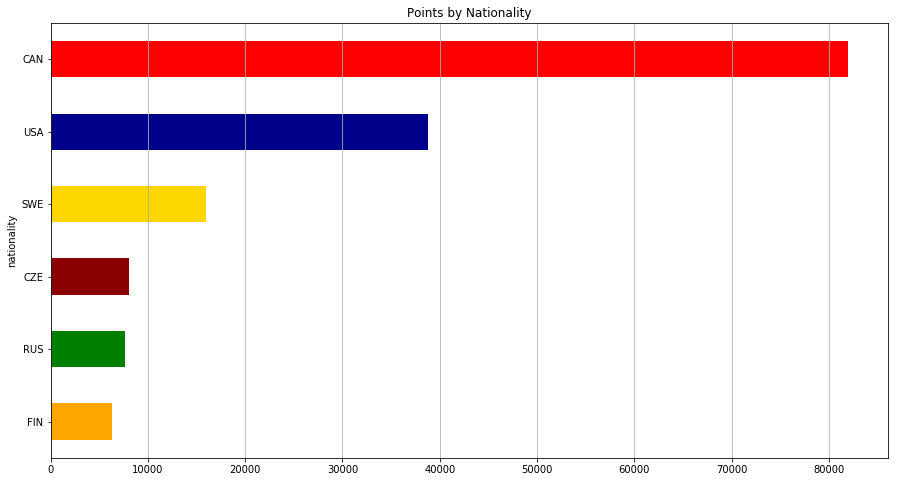

In [26]:
nat = player.groupby(['nationality'])['Points'].agg('sum').nlargest(6)
nat.sort_values(ascending=True).plot(kind='barh', 
                                     figsize = (15,8), 
                                     color=['orange', 'g', 'darkred', 'gold', 'darkblue', 'red'],
                                    title='Points by Nationality').grid(axis='x')

In [27]:
hits= player.groupby('hits').agg('sum')
hits.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,powerPlayGoals,powerPlayAssists,penaltyMinutes,...,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,franchiseId,GoalsPerMin,PointsPerMin,Points
hits,,,,,,,,,,,,,,,,,,,,,
0,301798132792401,1269538911133,2611163,148437483,43663,25744,263245,5785,11655,66180,...,661,108170,1832,123749081,9401812,15286590,3300404,1558.508537,4120.083986,69407
1,238371311715171,1002766558390,2062686,117397487,30877,18001,199482,3931,7533,63919,...,534,94982,-825,98592170,8343660,10461657,2602123,1095.941057,2890.729090,48878
2,143012698862126,601623447635,1235123,70584810,16852,9771,116358,2024,3676,44143,...,323,60925,-1842,59730248,5320062,5534500,1554051,598.862369,1579.433766,26623
3,76547556911244,322019637960,670425,37862744,8123,4872,60934,986,1667,25819,...,168,34129,-1289,32247145,2941487,2674112,831524,297.166553,768.186893,12995
4,37346427919111,157111970443,322495,18593778,3783,2335,29576,451,718,13549,...,77,16867,-641,15905805,1460669,1227304,402162,143.535921,362.123742,6118


In [28]:
teams.columns

Index(['team_id', 'franchiseId', 'shortName', 'teamName', 'abbreviation',
       'link', 'game_id', 'HoA', 'won', 'settled_in', 'head_coach', 'goals',
       'shots', 'hits', 'pim', 'powerPlayOpportunities', 'powerPlayGoals',
       'faceOffWinPercentage', 'giveaways', 'takeaways'],
      dtype='object')

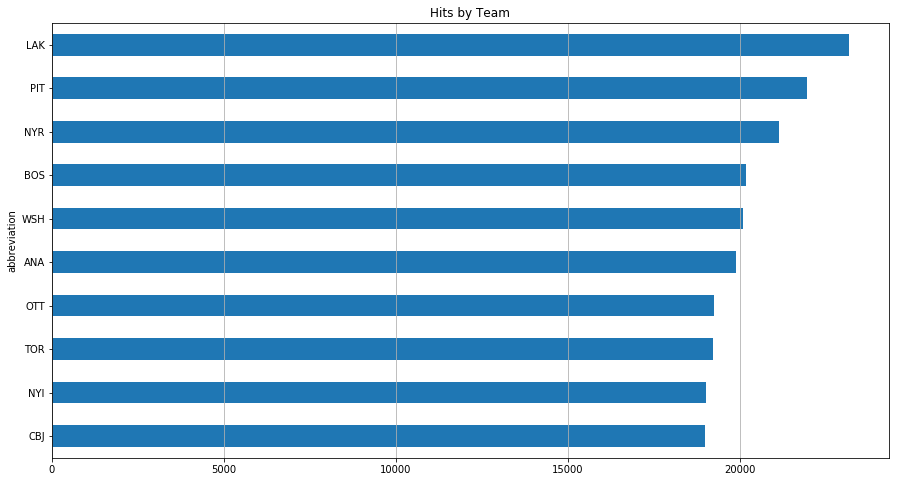

In [29]:
teamhits=player.groupby(['abbreviation'])['hits'].agg('sum').nlargest(10)
teamhits.sort_values(ascending=True).plot(kind='barh',
                                         figsize=(15,8),
                                         title='Hits by Team').grid(axis='x')

In [30]:
teams.faceOffWinPercentage =teams.faceOffWinPercentage.astype(int)
teams.won= teams.won.astype(int)

In [31]:
teams['TakeawayDiff']= (teams.takeaways - teams.giveaways)

In [32]:
teamwins = teams.groupby(['abbreviation'])['won'].agg('sum')
teamwins

abbreviation
ANA    423
ARI    157
ATL     34
BOS    465
BUF    276
CAR    319
CBJ    359
CGY    350
CHI    436
COL    332
DAL    372
DET    357
EDM    285
FLA    317
LAK    406
MIN    373
MTL    380
NJD    328
NSH    418
NYI    352
NYR    426
OTT    338
PHI    367
PHX    152
PIT    478
SJS    442
STL    445
TBL    449
TOR    341
VAN    360
VGK    110
WPG    326
WSH    461
Name: won, dtype: int64

In [33]:
teamgamesplayed = teams.groupby(['abbreviation'])['game_id'].agg('count')
teamgamesplayed.sort_values(ascending=False)

abbreviation
PIT    815
BOS    812
SJS    805
WSH    804
NYR    802
CHI    793
TBL    790
STL    788
NSH    787
LAK    783
ANA    774
MTL    751
DET    751
MIN    748
OTT    746
PHI    745
VAN    744
NYI    736
DAL    736
NJD    733
TOR    731
CBJ    731
COL    729
CGY    724
CAR    719
FLA    717
EDM    717
BUF    711
WPG    649
ARI    410
PHX    314
VGK    191
ATL     82
Name: game_id, dtype: int64

In [34]:
GameWinPercentage= teamwins/teamgamesplayed


In [35]:
GameWinPercentage.sort_values(ascending = False)


abbreviation
PIT    0.586503
VGK    0.575916
WSH    0.573383
BOS    0.572660
TBL    0.568354
STL    0.564721
CHI    0.549811
SJS    0.549068
ANA    0.546512
NYR    0.531172
NSH    0.531131
LAK    0.518519
MTL    0.505992
DAL    0.505435
WPG    0.502311
MIN    0.498663
PHI    0.492617
CBJ    0.491108
PHX    0.484076
VAN    0.483871
CGY    0.483425
NYI    0.478261
DET    0.475366
TOR    0.466484
COL    0.455418
OTT    0.453083
NJD    0.447476
CAR    0.443672
FLA    0.442120
ATL    0.414634
EDM    0.397490
BUF    0.388186
ARI    0.382927
dtype: float64

In [36]:
player['season'] = player.game_id.astype(str).str[:4]


In [37]:
player.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,link_x,franchiseId,shortName,teamName,abbreviation,link_y,GoalsPerMin,PointsPerMin,Points,season
0,2011030221,8467412,1,999,0,0,1,3,0,0,...,/api/v1/people/8467412,23,New Jersey,Devils,NJD,/api/v1/teams/1,0.0,0.0,0,2011
1,2011030221,8468501,1,1168,0,0,0,4,0,0,...,/api/v1/people/8468501,23,New Jersey,Devils,NJD,/api/v1/teams/1,0.0,0.0,0,2011
2,2011030221,8470609,1,558,0,0,2,1,0,0,...,/api/v1/people/8470609,23,New Jersey,Devils,NJD,/api/v1/teams/1,0.0,0.0,0,2011
3,2011030221,8471816,1,1134,0,0,1,4,0,0,...,/api/v1/people/8471816,23,New Jersey,Devils,NJD,/api/v1/teams/1,0.0,0.0,0,2011
4,2011030221,8472410,1,436,0,0,1,3,0,0,...,/api/v1/people/8472410,23,New Jersey,Devils,NJD,/api/v1/teams/1,0.0,0.0,0,2011


In [38]:
player.columns

Index(['game_id', 'player_id', 'team_id', 'timeOnIce', 'assists', 'goals',
       'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes',
       'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways',
       'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus',
       'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce',
       'firstName', 'lastName', 'nationality', 'birthCity', 'primaryPosition',
       'birthDate', 'link_x', 'franchiseId', 'shortName', 'teamName',
       'abbreviation', 'link_y', 'GoalsPerMin', 'PointsPerMin', 'Points',
       'season'],
      dtype='object')

In [39]:
season_stats = player.groupby(['player_id','team_id', 'season'], as_index= False).agg(
    {
        'timeOnIce':sum, #sum time on ice 
        'assists':sum, #sum assists
        'goals':sum,
        'shots':sum,
        'hits':sum,
        'powerPlayGoals':sum,
        'powerPlayAssists':sum,
        'penaltyMinutes':sum,
        'faceOffWins':sum,
        'faceoffTaken':sum,
        'takeaways':sum,
        'giveaways':sum,
        'shortHandedGoals':sum,
        'shortHandedAssists':sum,
        'blocked':sum,
        'plusMinus':sum,
        'evenTimeOnIce':sum,
        'shortHandedTimeOnIce':sum,
        'powerPlayTimeOnIce':sum,
        
        
    
    }


)

In [40]:
season_stats.shape

(8646, 22)

In [41]:
season_stats.season.unique()

array(['2010', '2013', '2014', '2011', '2012', '2015', '2016', '2017',
       '2018'], dtype=object)

In [42]:
player_info.head()

,player_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,link
0,8467412,Alexei,Ponikarovsky,UKR,Kiev,LW,1980-04-09,/api/v1/people/8467412
1,8468501,Anton,Volchenkov,RUS,Moscow,D,1982-02-25,/api/v1/people/8468501
2,8459670,Kimmo,Timonen,FIN,Kuopio,D,1975-03-18,/api/v1/people/8459670
3,8471233,Travis,Zajac,CAN,Winnipeg,C,1985-05-13,/api/v1/people/8471233
4,8455710,Martin,Brodeur,CAN,Montreal,G,1972-05-06,/api/v1/people/8455710


In [43]:
player_season = pd.merge(season_stats, player_info, on ='player_id', how = 'left')
player_season =pd.merge(season_stats, team_info, on = 'team_id', how = 'left')
player_season.head()

,player_id,team_id,season,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,franchiseId,shortName,teamName,abbreviation,link
0,8446485,17,2010,33946,6,6,60,59,0,0,...,16,3,31092,2718,136,12,Detroit,Red Wings,DET,/api/v1/teams/17
1,8448208,1,2013,94259,43,24,231,4,5,12,...,9,16,79753,246,14260,23,New Jersey,Devils,NJD,/api/v1/teams/1
2,8448208,1,2014,60473,18,11,119,13,2,5,...,8,-10,52621,36,7816,23,New Jersey,Devils,NJD,/api/v1/teams/1
3,8448208,4,2011,81465,42,20,196,15,8,18,...,15,0,65413,70,15982,16,Philadelphia,Flyers,PHI,/api/v1/teams/4
4,8448208,6,2012,35831,17,2,86,16,0,5,...,7,2,30713,11,5107,6,Boston,Bruins,BOS,/api/v1/teams/6


In [44]:
player_season = pd.merge(season_stats, player_info, on ='player_id')

In [45]:
player_season

,player_id,team_id,season,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,link
0,8446485,17,2010,33946,6,6,60,59,0,0,...,31092,2718,136,Kris,Draper,CAN,Toronto,C,1971-05-24,/api/v1/people/8446485
1,8448208,1,2013,94259,43,24,231,4,5,12,...,79753,246,14260,Jaromir,Jagr,CZE,Kladno,RW,1972-02-15,/api/v1/people/8448208
2,8448208,1,2014,60473,18,11,119,13,2,5,...,52621,36,7816,Jaromir,Jagr,CZE,Kladno,RW,1972-02-15,/api/v1/people/8448208
3,8448208,4,2011,81465,42,20,196,15,8,18,...,65413,70,15982,Jaromir,Jagr,CZE,Kladno,RW,1972-02-15,/api/v1/people/8448208
4,8448208,6,2012,35831,17,2,86,16,0,5,...,30713,11,5107,Jaromir,Jagr,CZE,Kladno,RW,1972-02-15,/api/v1/people/8448208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8641,8481442,13,2018,760,0,0,1,2,0,0,...,760,0,0,Brady,Keeper,CAN,Cross Lake,D,1996-06-05,/api/v1/people/8481442
8642,8481477,30,2018,1534,0,0,7,3,0,0,...,1434,86,14,Nico,Sturm,DEU,Augsburg,C,1995-05-03,/api/v1/people/8481477
8643,8481479,23,2018,1602,0,0,3,0,0,0,...,1602,0,0,Brogan,Rafferty,USA,WEST DUNDEE,D,1995-05-28,/api/v1/people/8481479
8644,8481481,26,2018,672,0,0,1,0,0,0,...,672,0,0,Blake,Lizotte,NaN,NaN,C,1997-12-13,/api/v1/people/8481481


In [46]:
player_season.columns

Index(['player_id', 'team_id', 'season', 'timeOnIce', 'assists', 'goals',
       'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes',
       'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways',
       'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus',
       'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce',
       'firstName', 'lastName', 'nationality', 'birthCity', 'primaryPosition',
       'birthDate', 'link'],
      dtype='object')

In [47]:
df= player_season

In [48]:
df.isnull().sum()

player_id               0
team_id                 0
season                  0
timeOnIce               0
assists                 0
goals                   0
shots                   0
hits                    0
powerPlayGoals          0
powerPlayAssists        0
penaltyMinutes          0
faceOffWins             0
faceoffTaken            0
takeaways               0
giveaways               0
shortHandedGoals        0
shortHandedAssists      0
blocked                 0
plusMinus               0
evenTimeOnIce           0
shortHandedTimeOnIce    0
powerPlayTimeOnIce      0
firstName               0
lastName                0
nationality             2
birthCity               3
primaryPosition         0
birthDate               0
link                    0
dtype: int64

In [49]:
df.dropna(inplace=True)

In [50]:
df.to_csv('final_data.csv')

In [51]:
df['GoalsPerMin']= (df.goals*60)/df.timeOnIce
df['PointsPerMin']=(df.assists + df.goals)*60/df.timeOnIce
df.head()

,player_id,team_id,season,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,powerPlayTimeOnIce,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,link,GoalsPerMin,PointsPerMin
0,8446485,17,2010,33946,6,6,60,59,0,0,...,136,Kris,Draper,CAN,Toronto,C,1971-05-24,/api/v1/people/8446485,0.010605,0.021210
1,8448208,1,2013,94259,43,24,231,4,5,12,...,14260,Jaromir,Jagr,CZE,Kladno,RW,1972-02-15,/api/v1/people/8448208,0.015277,0.042648
2,8448208,1,2014,60473,18,11,119,13,2,5,...,7816,Jaromir,Jagr,CZE,Kladno,RW,1972-02-15,/api/v1/people/8448208,0.010914,0.028773
3,8448208,4,2011,81465,42,20,196,15,8,18,...,15982,Jaromir,Jagr,CZE,Kladno,RW,1972-02-15,/api/v1/people/8448208,0.014730,0.045664
4,8448208,6,2012,35831,17,2,86,16,0,5,...,5107,Jaromir,Jagr,CZE,Kladno,RW,1972-02-15,/api/v1/people/8448208,0.003349,0.031816


In [52]:
df['Takeawaydiff']= (df.takeaways - df.giveaways)

In [53]:
df.columns

Index(['player_id', 'team_id', 'season', 'timeOnIce', 'assists', 'goals',
       'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes',
       'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways',
       'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus',
       'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce',
       'firstName', 'lastName', 'nationality', 'birthCity', 'primaryPosition',
       'birthDate', 'link', 'GoalsPerMin', 'PointsPerMin', 'Takeawaydiff'],
      dtype='object')

In [54]:
df.corr()

,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,...,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,GoalsPerMin,PointsPerMin,Takeawaydiff
player_id,1.000000,0.044527,-0.161309,-0.114421,-0.061565,-0.098201,-0.108219,-0.094608,-0.112232,-0.202471,...,-0.035832,-0.069526,-0.128036,-0.004848,-0.144748,-0.202327,-0.136839,0.014984,-0.023378,0.042543
team_id,0.044527,1.000000,0.005223,0.001809,0.001117,0.001338,0.003578,-0.002471,-0.003448,-0.008335,...,-0.004946,-0.004782,0.006396,0.001087,0.005477,0.005648,0.000823,0.012671,0.015022,0.022742
timeOnIce,-0.161309,0.005223,1.000000,0.831399,0.664843,0.853551,0.601024,0.546895,0.645900,0.506748,...,0.282737,0.357164,0.754279,0.197361,0.995083,0.691577,0.753407,0.206842,0.351853,-0.277831
assists,-0.114421,0.001809,0.831399,1.000000,0.788763,0.866004,0.353775,0.702849,0.874981,0.374501,...,0.265613,0.310272,0.428620,0.281521,0.808606,0.374206,0.884780,0.334122,0.589264,-0.144644
goals,-0.061565,0.001117,0.664843,0.788763,1.000000,0.886308,0.343529,0.839925,0.649266,0.343940,...,0.371152,0.216289,0.153667,0.233727,0.644726,0.200065,0.795088,0.583329,0.640478,0.096951
shots,-0.098201,0.001338,0.853551,0.866004,0.886308,1.000000,0.485619,0.748217,0.714255,0.444562,...,0.329258,0.278521,0.411828,0.190773,0.838996,0.397700,0.849578,0.420032,0.539635,-0.065636
hits,-0.108219,0.003578,0.601024,0.353775,0.343529,0.485619,1.000000,0.217405,0.162272,0.675098,...,0.189808,0.217544,0.505947,0.097115,0.618995,0.509210,0.265803,0.093442,0.107342,-0.157236
powerPlayGoals,-0.094608,-0.002471,0.546895,0.702849,0.839925,0.748217,0.217405,1.000000,0.679515,0.250696,...,0.175883,0.140212,0.133121,0.113814,0.512519,0.091162,0.808451,0.458230,0.539921,-0.018932
powerPlayAssists,-0.112232,-0.003448,0.645900,0.874981,0.649266,0.714255,0.162272,0.679515,1.000000,0.237654,...,0.146386,0.177893,0.300862,0.120229,0.606426,0.193994,0.881434,0.272088,0.499369,-0.187812
penaltyMinutes,-0.202471,-0.008335,0.506748,0.374501,0.343940,0.444562,0.675098,0.250696,0.237654,1.000000,...,0.149644,0.179659,0.356870,0.079120,0.518939,0.345495,0.305562,0.113616,0.153038,-0.152835


In [55]:
df.to_csv('final_data.csv')

# Hypothesis Testing

Text(0.5, 1.0, 'Penalties Distribution by Minutes in a Season')

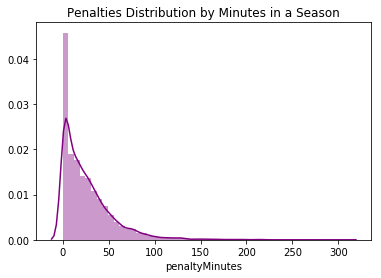

In [56]:
dist1=sns.distplot(df.penaltyMinutes, color='purple')
dist1.set_title('Penalties Distribution by Minutes in a Season')

In [57]:
df.penaltyMinutes.describe()

count    8642.000000
mean       26.229924
std        28.248398
min         0.000000
25%         6.000000
50%        18.000000
75%        38.000000
max       307.000000
Name: penaltyMinutes, dtype: float64

Text(0.5, 1.0, 'Distribution of Hits in a Season')

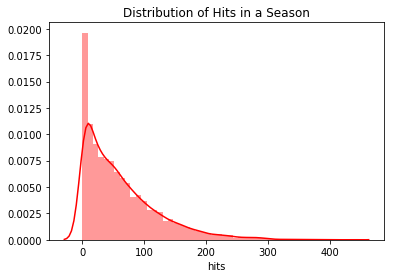

In [58]:
dist2=sns.distplot(df.hits, color='r')
dist2.set_title('Distribution of Hits in a Season')

In [59]:
df.hits.describe()

count    8642.000000
mean       62.461699
std        59.886284
min         0.000000
25%        16.000000
50%        46.000000
75%        91.000000
max       434.000000
Name: hits, dtype: float64

In [60]:
df.dtypes

player_id                 int64
team_id                   int64
season                   object
timeOnIce                 int64
assists                   int64
goals                     int64
shots                     int64
hits                      int64
powerPlayGoals            int64
powerPlayAssists          int64
penaltyMinutes            int64
faceOffWins               int64
faceoffTaken              int64
takeaways                 int64
giveaways                 int64
shortHandedGoals          int64
shortHandedAssists        int64
blocked                   int64
plusMinus                 int64
evenTimeOnIce             int64
shortHandedTimeOnIce      int64
powerPlayTimeOnIce        int64
firstName                object
lastName                 object
nationality              object
birthCity                object
primaryPosition          object
birthDate                object
link                     object
GoalsPerMin             float64
PointsPerMin            float64
Takeaway

Hypothesis Test: Chi^2 Contingency
we want to see whether there is a statistical difference between Nationality of a player and the position they play

Null Hypothesis, there is no statistical difference between a player's nationality and the position they play.

Alternate Hypothesis, there is a relationship between a player's nationality and the position they play.

In [61]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2
# contingency table
table =  pd.crosstab(df['nationality'],[df['primaryPosition']])

stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
#interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f)' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (regject H0)')
else:
    print('Independent (fail to reject H0)')
#interpret p-value
alpha= 1-prob
print('signigicance=%.3f, p=%.3f,' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else: 
    print('Independent (fail to reject)')


dof=72
[[8.43901875e-01 1.02580421e+00 6.01943994e-01 5.28349919e-01]
 [9.28292062e+00 1.12838463e+01 6.62138394e+00 5.81184911e+00]
 [2.81300625e-01 3.41934737e-01 2.00647998e-01 1.76116640e-01]
 [4.21950937e+00 5.12902106e+00 3.00971997e+00 2.64174960e+00]
 [1.22618942e+03 1.49049352e+03 8.74624624e+02 7.67692432e+02]
 [2.75674612e+01 3.35096043e+01 1.96635038e+01 1.72594307e+01]
 [1.00705624e+02 1.22412636e+02 7.18319833e+01 6.30497570e+01]
 [1.71593381e+01 2.08580190e+01 1.22395279e+01 1.07431150e+01]
 [1.80032400e+01 2.18838232e+01 1.28414719e+01 1.12714649e+01]
 [7.56698681e+01 9.19804443e+01 5.39743115e+01 4.73753761e+01]
 [7.03251562e+00 8.54836843e+00 5.01619995e+00 4.40291599e+00]
 [1.12520250e+00 1.36773895e+00 8.02591993e-01 7.04466559e-01]
 [8.43901875e-01 1.02580421e+00 6.01943994e-01 5.28349919e-01]
 [8.43901875e-01 1.02580421e+00 6.01943994e-01 5.28349919e-01]
 [1.96910437e+00 2.39354316e+00 1.40453599e+00 1.23281648e+00]
 [5.34471187e+00 6.49676001e+00 3.81231196e+00 3

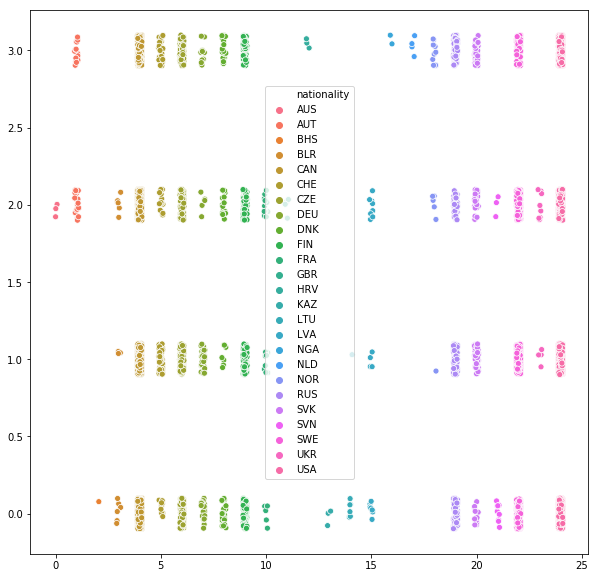

In [62]:
df.nationality = pd.Categorical(df.nationality)
df.primaryPosition = pd.Categorical(df.primaryPosition)

plt.figure(figsize=(10,10))
axes = sns.scatterplot(x=df.nationality.cat.codes+np.random.uniform(-0.1,0.1, len(df)), 
                       y=df.primaryPosition.cat.codes+np.random.uniform(-0.1,0.1, len(df)),
                       hue = df.nationality,
                      )


## Hypothesis test 2 ##
Is there a statistical difference betweeen the position a player plays and the number of hits a player has in a season.

Null hypothesis, all skaters have the same amount of hits, regardless of position and are not statistically different

Alternate hypothesis, there is a statistial difference between number of hits a player has in season and their position.

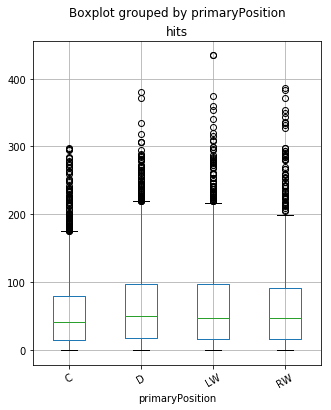

In [64]:
df.boxplot('hits', 'primaryPosition', rot=30, figsize=(5,6))

In [65]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df['hits'], df['primaryPosition'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     C      D   10.522  0.001  6.3205 14.7235   True
     C     LW  11.1119  0.001  6.2887 15.9351   True
     C     RW   8.1467  0.001  3.1313 13.1622   True
     D     LW   0.5899    0.9 -4.0518  5.2317  False
     D     RW  -2.3752 0.5776 -7.2164  2.4659  False
    LW     RW  -2.9652 0.4911 -8.3547  2.4244  False
----------------------------------------------------


In [66]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df['goals'], df['primaryPosition'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     C      D   -6.047  0.001 -6.6508 -5.4432   True
     C     LW   -0.044    0.9 -0.7371  0.6492  False
     C     RW   0.1652    0.9 -0.5556   0.886  False
     D     LW    6.003  0.001   5.336  6.6701   True
     D     RW   6.2122  0.001  5.5165   6.908   True
    LW     RW   0.2092 0.8956 -0.5654  0.9837  False
----------------------------------------------------


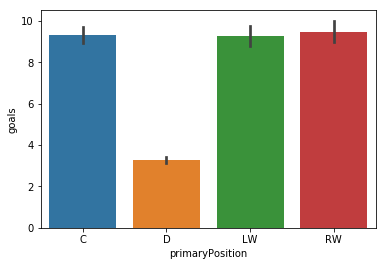

In [67]:
bar = sns.barplot(x= 'primaryPosition', y= 'goals', data =df)

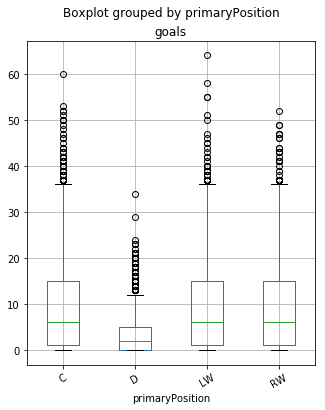

In [68]:
df.boxplot('goals', 'primaryPosition', rot=30, figsize=(5,6))

In [69]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df['goals'], df['nationality'])
mc_results = mc.tukeyhsd()
print(mc_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   AUS    AUT  13.7273 0.6446  -6.1271 33.5816  False
   AUS    BHS  -0.3333    0.9 -38.3515 37.6849  False
   AUS    BLR  11.6667    0.9  -9.1568 32.4901  False
   AUS    CAN   6.7605    0.9 -12.2551 25.7761  False
   AUS    CHE   6.3095    0.9 -12.9883 25.6074  False
   AUS    CZE    7.594    0.9 -11.4945 26.6826  False
   AUS    DEU   5.7158    0.9 -13.7551 25.1868  False
   AUS    DNK   9.6667    0.9  -9.7829 29.1162  False
   AUS    FIN   8.0756    0.9 -11.0392 27.1904  False
   AUS    FRA   4.6267    0.9 -15.4907  24.744  False
   AUS    GBR  10.9167    0.9   -14.23 36.0633  False
   AUS    HRV      0.0    0.9 -26.8829 26.8829  False
   AUS    KAZ     12.0    0.9 -14.8829 38.8829  False
   AUS    LTU   7.6667    0.9 -15.0536 30.3869  False
   AUS    LVA   3.5614    0.9 -16.8934 24.0162  False
   AUS    NGA   0.6667    0.

# Model Development